# Tutorial 1- Optimal Control for Discrete State

Please execute the cell below to initialize the notebook environment.


In [1]:
import numpy as np                 # import numpy
import scipy               # import scipy
import random                      # import basic random number generator functions
from scipy.linalg import inv

import matplotlib.pyplot as plt    # import matplotlib
%matplotlib inline

from IPython import display

fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
#plt.style.use('seaborn')

---

## Tutorial objectives

In this tutorial, we will implement a binary HMM task, where the agent seeks reward from two boxes without observing the states of the box. The agent keeps updating beliefs on the boxes, which is the posterior of the boxes' states given past observations, and makes decision on actions. 


---

## Task Description

There are two boxes. The box can be in a high-rewarding state ($s=1$), which means that a reward will be delivered with high probabilty $rp_{high}$; or the box can be in low-rewarding state ($s=0$), and the reward will be delivered with low probabilty $rp_{low}$.

The states of the two boxes are latent. At a certain time, only one of the sites can be in high-rewarding state, and the other box will be the opposite. The states of the two boxes switches with a certain probability $p_{sw}$. 

![alt text](switching.png "Title")


The agent may stay at one site for sometime. As the agent accumulates evidence about the state of the box on that site, it may choose to stay or switch to the other side with a switching cost $c$. The agent has beliefs on the states of the boxes, which is the posterior probability of the state being high-rewarding given all the past observations. Consider the belief on the state of the left box, we have 

$$b(s_t) = p(s_t = 1 | o_{0:t}, l_{0:t}, a_{0:t-1})$$

where $o$ is the observation that whether a reward is obtained, $l$ is the location of the agent, $a$ is the action of staying or switching. 

Since the two boxes are completely anti-correlated, i.e. only one of the boxes is high-rewarded at a certain time, the the other one is low-rewarded, the belief on the two boxes should sum up to be 1. 

The policy of the agent depends on a threshold on beliefs. When the belief on the current box gets lowerer than the threshold $\theta$, the agent will switch to the other side. In other words, the agent will choose to switch when it is confident enough that the other side is high rewarding. 

When a reward is delivered at time *t* from the site the agent is at, $o_t = 1$; otherwise, $o_t = 0$. 

### Exercise 1: Binary HMM task
In this excercise, we define the binary HMM task as described above. 

** Suggestions **
* The code has been wrapped into an object for this binary HMM process. A lazy policy function `def policy_lazy(self, belief, loc)` is provided in which the agent always chooses *"stay"*. 
* You will need to fill the code for a policy based on threshold in `def policy_threshold(self, threshold, belief, loc)`. The input of the function is the belief vector of the two boxes, the location, and the threshold. When the agent is at a certain site, when the belief on that box drops below the threshold, the agent chooses to switch, otherwise the agent stays. 
* Specifically, the value of the location at timet *t* can be 0, meaning the left box; or 1, meaning the right box. The belief at time *t* is 2-dimensional, with the first element being the belief that the left box is high-rewarding and the second element being the beleif that the right box is high-rewarding. You will need to return the action for time *t*, which takes the value of *"stay"* or *"switch"*.

In [2]:
class binaryHMM():
    def __init__(self, params, choose_policy = "threshold"):
        self.params = params
        self.choose_policy = choose_policy
    
    def generateProcess(self):  
        """
        This function generates the dynamics
        """
        
        T, p_sw, rp_high, rp_low, threshold = self.params
        world_state = np.zeros((2, T), int)  # value :1: high-rewarding box; 0: low-rewarding box
        loc = np.zeros(T, int)               # 0: left box, 1: right box
        obs = np.zeros(T, int)               # 0: no food, 1: get food
        act = np.empty(T, dtype='object')    # "stay", or "switch" 
        belief = np.zeros((2, T), float)     # the probability that a certain box is in high-rewarding state,
                                             # the beliefs on the two boxes sum up to be 1


        p = np.array([1 - p_sw, p_sw])  # transition probability to good state
        rp = np.array([rp_low, rp_high])
        rp_mat = np.array([[1 - rp_high, rp_high], [1 - rp_low, rp_low]])

        for t in range(T):
            if t == 0:
                world_state[0, t] = 1    # high-rewarding box
                world_state[1, t] = 1 - world_state[0, t]
                loc[t] = 0
                obs[t] = 0
                belief_0 = np.random.random(1)[0]
                belief[:, t] = np.array([belief_0, 1 - belief_0])

                act[t] = self.policy(threshold, belief[:, t], loc[t])

            else:
                world_state[0, t] = np.random.binomial(1, p[world_state[0, t - 1]])
                world_state[1, t] = 1 - world_state[0, t]

                if act[t - 1] == "stay":
                    loc[t] = loc[t - 1]
                else:  
                    loc[t] = 1 - loc[t - 1]

                # new observation
                obs[t] = np.random.binomial(1, rp[world_state[loc[t], t-1]])

                # update belief posterior, p(s[t] | obs(0-t), act(0-t-1))
                belief_0 = (belief[0, t-1] * p_sw  + belief[1, t-1] * (1 - p_sw)) * rp_mat[loc[t], obs[t]]
                belief_1 = (belief[1, t - 1] * p_sw + belief[0, t - 1] * (1 - p_sw)) * rp_mat[1-loc[t], obs[t]]

                belief[0, t] = belief_0 / (belief_0 + belief_1)
                belief[1, t] = belief_1 / (belief_0 + belief_1)

                act[t] = self.policy(threshold, belief[:, t], loc[t])

        return belief, loc, act, obs, world_state
    
    
    def policy(self, threshold, belief, loc):
        """
        This function chooses policy. 
        """
        if self.choose_policy == "threshold":
            act = self.policy_threshold(threshold, belief, loc)
        if self.choose_policy == "lazy":
            act = self.policy_lazy(belief, loc)
        
        return act
    
    def policy_threshold(self, threshold, belief, loc):
        """
        This function is the policy based on threshold
        """
        if belief[loc]  <= threshold:
            act = "switch"
        else:
            act = "stay"

        return act
    
    def policy_lazy(self, belief, loc):
        """
        This function is a policy where stay is also taken
        """
        act = "stay"

        return act
    
    
    def plot_dynamics(self, belief, loc, act, obs, world_state):
        "Plot the dynamics of 100 time points"
        T = len(obs)

        showlen = min(T, 300)
        startT = 0

        endT = startT + showlen
        showT = range(startT, endT)
        time_range = np.linspace(0, showlen - 1)

        #fig, [ax0, ax1, ax_loc, ax2, ax3] = plt.subplots(5, 1, figsize=(12, 8))
        fig, [ax0, ax1, ax_loc] = plt.subplots(3, 1, figsize=(15, 6))
        
        ax0.plot(world_state[0, showT], color='dodgerblue', markersize=10, linewidth=3.0)
        ax0.set_ylabel('Fish state', rotation=360, fontsize=18)
        ax0.yaxis.set_label_coords(-0.1, 0.25)
        ax0.set_xticks([0, showlen, showlen])
        ax0.tick_params(axis='both', which='major', labelsize=18)
        ax0.set_xlim([0, showlen])
        ax0.set_ylim([0, 1.1])
        ax0.set_yticks([0, 1])
        ax0.tick_params(axis='both', which='major', labelsize=18)
        labels = [item.get_text() for item in ax0.get_yticklabels()]
        labels[0] = 'Right'
        labels[-1] = 'Left'
        ax0.set_yticklabels(labels)

#         ax3.plot(world_state[1, showT], color='dodgerblue', markersize=10, linewidth=3.0)
#         ax3.set_ylabel('Right box', rotation=360, fontsize=18)
#         ax3.yaxis.set_label_coords(-0.1, 0.25)
#         ax3.tick_params(axis='both', which='major', labelsize=18)
#         ax3.set_xlim([0, showlen])
#         ax3.set_xticks([0, showlen, showlen])

        ax1.plot(belief[0, showT], color='dodgerblue', markersize=10, linewidth=3.0)
        ax1.plot(time_range, threshold * np.ones(time_range.shape), 'r--')
        ax1.plot(time_range, (1 - threshold) * np.ones(time_range.shape), 'c--')
        ax1.yaxis.set_label_coords(-0.1, 0.25)
        ax1.set_ylabel('Belief on \n left', rotation=360, fontsize=18)
        ax1.tick_params(axis='both', which='major', labelsize=18)
        ax1.set_xlim([0, showlen])
        ax1.set_yticks([0, 1])
        ax1.set_ylim([0, 1.1])
        ax1.set_xticks([0, showlen, showlen])
        
        ax2 = ax1.twinx()
        ax2.plot(time_range, threshold * np.ones(time_range.shape), 'r--')
        ax2.plot(time_range, (1 - threshold) * np.ones(time_range.shape), 'c--')  
        ax2.set_yticks([threshold, 1 - threshold])
        ax2.set_ylim([0, 1.1])
        ax2.tick_params(axis='both', which='major', labelsize=18)
        labels = [item.get_text() for item in ax2.get_yticklabels()]
        labels[0] = 'threshold to switch \n from left to right'
        labels[-1] = 'threshold to switch \n from right to left'
        ax2.set_yticklabels(labels)
        
        
        act_int = (act == "switch" ).astype(int)
        ax_loc.plot(1 - loc[showT], 'g.-', markersize=12, linewidth=5)
        ax_loc.set_ylabel('Fish state', rotation=360, fontsize=18)
        ax_loc.plot((act_int[showT] - .1) * .8, 'v', markersize=10, label = 'action')
        ax_loc.plot(obs[showT] * .5, '*', markersize=5, label = 'reward')
        ax_loc.legend(loc="upper right", fontsize = 12)
        ax_loc.set_xlim([0, showlen])
        ax_loc.set_ylim([0, 1])
        ax_loc.set_xticks([0, showlen, showlen])
        ax_loc.tick_params(axis='both', which='major', labelsize=14)
        labels = [item.get_text() for item in ax_loc.get_yticklabels()]
        labels[0] = 'Right'
        labels[-1] = 'Left'
        ax_loc.set_yticklabels(labels)

#         ax2.plot(belief[1, showT], color='dodgerblue', markersize=10, linewidth=3.0)
#         ax2.plot(time_range, threshold * np.ones(time_range.shape), 'r--')
#         ax2.set_xlabel('time', fontsize=18)
#         ax2.yaxis.set_label_coords(-0.1, 0.25)
#         ax2.set_ylabel('Belief on  \n  right box', rotation=360, fontsize=18)
#         ax2.tick_params(axis='both', which='major', labelsize=18)
#         ax2.set_xlim([0, showlen])
#         ax2.set_ylim([0, 1])
#         ax2.set_xticks([0, showlen, showlen])

        plt.tight_layout()
        plt.show()
        
    
    def belief_histogram(self, belief, bins = 100):
        plt.hist(belief, bins)
        plt.show()



### Exercise 2: Use the binary HMM module to plot dynamics and belief distribution

In Excercise 1, we have defined a class for the binary HMM tasl. Now in this excercise, we used the module to generate the dynamics. With the generated data, we will see what the dynamic looks like, and how the beliefs are distributed, etc.

** Suggestions **
* With the class defined above, create an object of `binaryHMM` given parameters of the dynamic *params* and a parameter for policy. 
* The parameter for policy can be either *"lazy"* or *"threshold"*. In the following example the policy is the lazy policy. After you compelete the code for the policy based on threshold in Excercise 1, comment the line using the "lazy" policy, and uncomment the line with "threshold" policy".
* We have provided an example of the parameters. You can play with the parameters to see the dynamics.
* Plot the histgram of the belief states to check the distributions.

In [3]:
T = 10000
p_sw = .95          # state transiton probability
rp_high = .4
rp_low = 0.1 
threshold = .2    # threshold of belief below which switching is taken

params = [T, p_sw, rp_high, rp_low, threshold]

#binaryHMM_test = binaryHMM(params, "lazy")
binaryHMM_test = binaryHMM(params, "threshold")


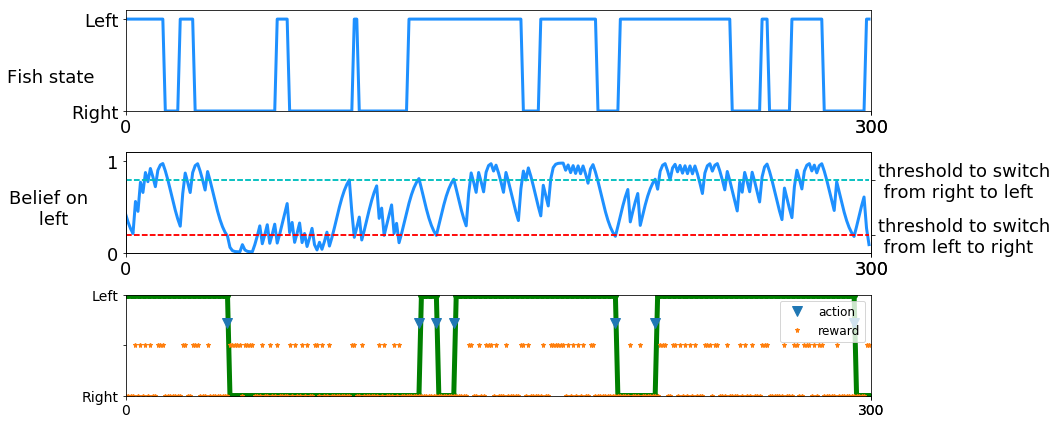

In [4]:
"""
Plot the dynamics of the binaryHMM task
"""
belief, loc, act, obs, world_state = binaryHMM_test.generateProcess()
binaryHMM_test.plot_dynamics(belief, loc, act, obs, world_state)

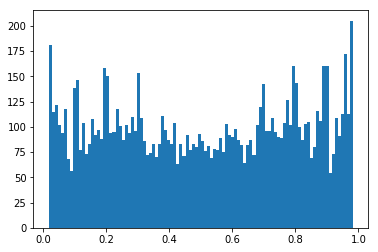

In [5]:
"""
Check the distribution of beliefs.
"""
binaryHMM_test.belief_histogram(belief[0, :]) # histgram of the belief on the left box

### Exercise 3: Utility function 
Now we have generated the behavioral data of the agent. Let's calculate the utility of the agent with a particular policy. 

Specifically, the utility function can be defined as the reward rate during a single trial.

$$u(\theta) = (\sum_t r_t - c\cdot 1_{a_t = "switch"})/ T$$ 

**Suggestions**
* Fill in the function `utility_function(obs, act, cost_sw)` given a sequence of observations, actions, and the cost of switching. 

In [6]:
def utility_function(obs, act, cost_sw):
    """
    utility function 
    """
    act_int = (act == "switch" ).astype(int)

    T = len(obs)   
    utility = (np.sum(obs) - np.sum(act_int) * cost_sw) / T

    return utility

### Exercise 4: Utility function vs threshold 
Now we would like to check relation between the utility funtion and the threshold. We have provided the code for plotting the curves of the utility function and the threshold. Fill in the parmeter you are interested, and see how the utility curves vary from case to case. 

With other parameters fixed but the threshold, we are able to find the optimal threshold $\theta^*$ that gives the highest utility. That turns out to be the optimal policy for the agent given the dynamic parameters.


In [7]:
# Brute force for optimal policy, what is the best threshold
# This function will be needed for the second excercise 
def utility_threshold(params, cost_sw, step):
    threshold_array = np.arange(0, 1 + step, step)
    utility_array = np.zeros(threshold_array.shape)
    
    T, p_sw, rp_high, rp_low, _ = params
    
    for i in range(len(threshold_array)):
        threshold = threshold_array[i]
        
        params = [T, p_sw, rp_high, rp_low, threshold]
        binaryHMM_test = binaryHMM(params)
        _, _, act, obs, _ = binaryHMM_test.generateProcess()
        
        utility_array[i] = utility_function(obs, act, cost_sw)
    
    return threshold_array, utility_array

def plot_utility_threshold(params, cost_sw, step = 0.05):
    threshold_array, utility_array = utility_threshold(params, cost_sw, step)

    fig_, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.plot(threshold_array, utility_array)
    ax.set_ylim([np.min(utility_array), np.max(utility_array)])
    ax.set_title('threshold vs utility with switching cost c = %.2f'%cost_sw, fontsize = 20)
    ax.set_xlabel('threshold', fontsize = 16)
    ax.set_ylabel('utility', fontsize = 16)
    plt.show()

In [8]:
# T = 10000
# p_sw = .95          # state transiton probability
# rp_high = .7
# rp_low = .3 #.2
cost_sw = 1

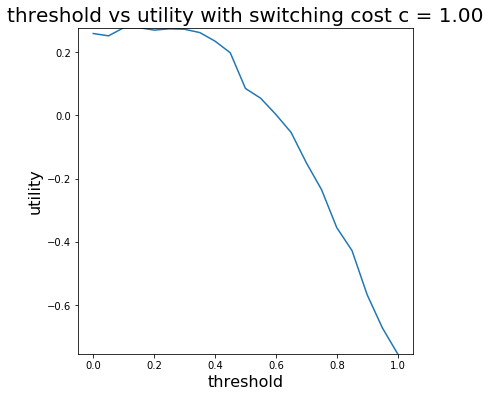

In [9]:
params = [T, p_sw, rp_high, rp_low, _]
plot_utility_threshold(params, cost_sw)

when the agent is at different site, the observation and the evidence is different. 

stronger evidence gives more discrete beliefs. 

1. write the function of the policy 
f(obs, loc, par) = act

2, default dynamic, just wait
plug in the policy the function 
can have a lazy function f(obs, loc) = act_stay, then the students need to define the new policy function, and use that to generate the dynamic

use "stay" or "switch" for the two actions, string type

3. evaluate the values 

4. for loop goes over the thresholds, compute the value, give a funtion to plot the values vs thresholds

5. change the cost, plot value vs threshold curves

6. histogram of beliefs, explain the plateau

7. change the probability trainsiton, reward probabilty, switching cost